# 範例 : (Kaggle)房價預測
***
- 以下用房價預測資料, 觀察降低資料偏態的影響

# [教學目標]
- 以下用房價預測資料, 觀察降低偏態的影響

# [範例重點]
- 觀察原始數值的散佈圖, 以及線性迴歸分數 (Out[4], Out[5]) 
- 觀察使用log1p降偏態時, 對於分布與迴歸分數的影響 (In[6], Out[6])
- 觀察使用box-cox(λ=0.15)時, 對於分布與迴歸分數的影響 (In[7], Out[7])
- 觀察使用sqrt(box-cox, λ=0.5)時, 對於分布與迴歸分數的影響 (In[8], Out[8])

In [1]:
#####特徵工程準備#####

#####Step1 載入套件#####
import pandas as pd
import numpy as np
import os
import copy
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
#####Step2 讀取文件#####
data_path = 'data2/'
df_train = pd.read_csv(data_path + 'house_train.csv.gz')
df_test = pd.read_csv(data_path + 'house_test.csv.gz')
#####Step3 提出X與Y#####
train_Y = np.log1p(df_train['SalePrice'])
ids = df_test['Id']
df_train = df_train.drop(['Id','SalePrice'], axis = 1)
df_test = df_test.drop(["Id"], axis = 1)
df = pd.concat([df_test,df_train])
#####Step4 顯示前五筆處理結果#####

df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [10]:
######只取 int64, float64 兩種數值型欄位, 存於 num_features 中 ######
num_features = []
for dtype, feature in zip(df.dtypes,df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)
print(f'{len(num_features)} Numeric Features : {num_features}\n')
###### 削減文字型欄位, 只剩數值型欄位 ######
df = df[num_features]
df= df.fillna(-1)
MMEncoder = MinMaxScaler()
train_num = train_Y.shape[0]
df.head()

36 Numeric Features : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']



,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20,80.0,11622,5,6,1961,1961,0.0,468.0,144.0,...,730.0,140,0,0,0,120,0,0,6,2010
1,20,81.0,14267,6,6,1958,1958,108.0,923.0,0.0,...,312.0,393,36,0,0,0,0,12500,6,2010
2,60,74.0,13830,5,5,1997,1998,0.0,791.0,0.0,...,482.0,212,34,0,0,0,0,0,3,2010
3,60,78.0,9978,6,6,1998,1998,20.0,602.0,0.0,...,470.0,360,36,0,0,0,0,0,6,2010
4,120,43.0,5005,8,5,1992,1992,0.0,263.0,0.0,...,506.0,0,82,0,0,144,0,0,1,2010


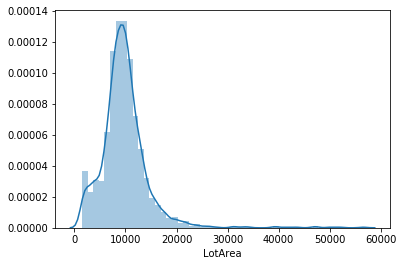

In [12]:
# 顯示 LotArea 的散佈圖
sns.distplot(df['LotArea'][:train_num])
plt.show()



In [23]:
# df_mm = MMEncoder.fit_transform(df)
# train_X = df_mm[:train_num]
# estimator = LinearRegression()
# cross_val_score(estimator, train_X, train_Y, cv=5).mean()

#####計算基礎分數#####
df_mm = MMEncoder.fit_transform(df)
train_X = df_mm[:train_num]
estimator = LinearRegression()
cross_val_score(estimator,train_X,train_Y,cv = 5).mean()

D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


-640516976923553.5

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


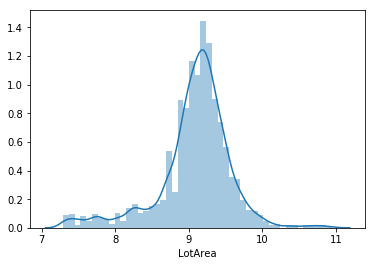

-5541318469649.761


D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [30]:
# 將 LotArea 取 log1p 後, 看散佈圖, 並計算分數
# df_fixed = copy.deepcopy(df)
# df_fixed['LotArea'] = np.log1p(df_fixed['LotArea'])
# sns.distplot(df_fixed['LotArea'][:train_num])
# plt.show()

# df_fixed = MMEncoder.fit_transform(df_fixed)
# train_X = df_fixed[:train_num]
# estimator = LinearRegression()
# print(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

# 將 LotArea 取 log1p 後, 看散佈圖, 並計算分數
df_fixed = copy.deepcopy(df)  #複製整個欄位
df_fixed['LotArea'] = np.log1p(df_fixed['LotArea']) #對LotArea取 log1p 
sns.distplot(df_fixed['LotArea'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LinearRegression()
print(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


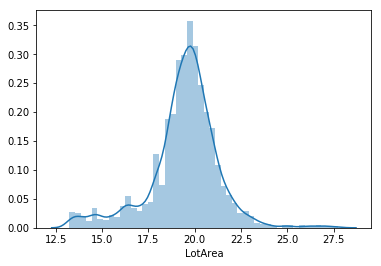

-144012832367639.44


D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [32]:
# 將 LotArea 取 boxcox 後, 看散佈圖, 並計算分數
from scipy import stats
df_fixed = copy.deepcopy(df)
df_fixed['LotArea'] = stats.boxcox(df_fixed['LotArea'], lmbda=0.15)
sns.distplot(df_fixed['LotArea'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LinearRegression()
print(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

D:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


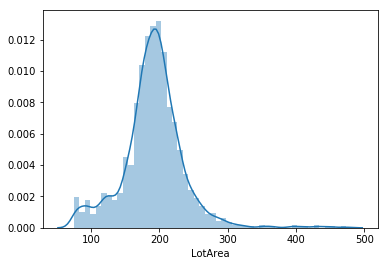

-35030247253667.27


D:\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [33]:
# 將 LotArea 取 sqrt (box-cox : alpha=0.5) 後, 看散佈圖, 並計算分數
df_fixed = copy.deepcopy(df)
df_fixed['LotArea'] = stats.boxcox(df['LotArea'], lmbda=0.5)
sns.distplot(df_fixed['LotArea'][:train_num])
plt.show()

df_fixed = MMEncoder.fit_transform(df_fixed)
train_X = df_fixed[:train_num]
estimator = LinearRegression()
print(cross_val_score(estimator, train_X, train_Y, cv=5).mean())

# 作業1 
* 試著在鐵達尼的票價 (Fare) 欄位中使用對數去偏 (log1p) , 結果是否更好?

# 作業2
* 最後的 boxcox 區塊直接執行會造成錯誤, 起因為輸入值有負值, 請問如何修正後可以使用 boxcox?(Hint : 試圖修正資料)